In [13]:
!pip install lightgbm

In [1]:
import pandas  as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
from sklearn.impute import SimpleImputer
import warnings
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc ,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import time
warnings.filterwarnings(action='ignore')

In [3]:
train = pd.read_csv('output_merged.csv')
train.shape

(70000, 136)

In [4]:
t = train.sample(1000)

In [5]:

t.to_csv('new_file.csv', index=False)


In [6]:
t.head()

,stream,src_mac,dst_mac,src_ip,dst_ip,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
65865,6,dc:a6:32:c9:e5:a4,Google Nest Mini Speaker,192.168.137.162,192.168.137.121,53124,8009,1413.103091,0.093510,2,...,0.0,297.0,12.0,34.05,4820.786842,20.00,0.0,20.00,92.0,XSS
40104,8,3c:18:a0:41:c3:a0,Nest Indoor Camera,35.185.101.66,192.168.137.196,443,52241,30.484405,0.022621,3,...,12.0,102.0,49.0,56.20,2068.589474,102.00,12.0,90.00,2.0,SqlInjection
8040,210,Netatmo Camera,3c:18:a0:41:c3:a0,192.168.137.58,51.145.143.28,58952,443,1322.396470,0.000801,1,...,12.0,1456.0,49.5,401.60,362816.568421,532.25,12.0,520.25,6.0,Backdoor_Malware
32299,117,3c:18:a0:41:c3:a0,TP-Link Tapo Camera,192.168.137.1,192.168.137.91,53,40191,52.914139,0.000119,2,...,70.0,154.0,154.0,137.20,1188.378947,154.00,154.0,0.00,2.0,CommandInjection
52048,11,Amazon Echo Dot 1,3c:18:a0:41:c3:a0,192.168.137.254,34.158.253.218,52280,4070,56.336455,0.000628,2,...,0.0,48.0,12.0,13.65,220.871053,19.25,0.0,19.25,74.0,Uploading_Attack


In [7]:
train.columns

Index(['stream', 'src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'src_port',
       'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst',
       ...
       'min_p', 'max_p', 'med_p', 'average_p', 'var_p', 'q3_p', 'q1_p',
       'iqr_p', 'l3_ip_dst_count', 'label'],
      dtype='object', length=136)

In [8]:
train.select_dtypes('object').columns

Index(['src_mac', 'dst_mac', 'src_ip', 'dst_ip', 'handshake_version',
       'tls_server', 'http_request_method', 'http_host', 'user_agent',
       'dns_server', 'device_mac', 'eth_src_oui', 'eth_dst_oui',
       'highest_layer', 'http_uri', 'http_content_type', 'label'],
      dtype='object')

In [9]:
train.select_dtypes('number').columns

Index(['stream', 'src_port', 'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp',
       'l4_udp', 'ttl', 'eth_size',
       ...
       'sum_p', 'min_p', 'max_p', 'med_p', 'average_p', 'var_p', 'q3_p',
       'q1_p', 'iqr_p', 'l3_ip_dst_count'],
      dtype='object', length=119)

In [10]:
train.isnull().sum() / train.shape[0] *100

stream             0.000000
src_mac            0.000000
dst_mac            0.000000
src_ip             7.915714
dst_ip             7.915714
                     ...   
q3_p               0.000000
q1_p               0.000000
iqr_p              0.000000
l3_ip_dst_count    0.000000
label              0.000000
Length: 136, dtype: float64

In [11]:
nan_percentage = train.isnull().sum() / train.shape[0] * 100
high_nan_columns = nan_percentage[nan_percentage > 60]
high_nan_columns

dns_query_type    92.645714
dtype: float64

In [12]:
train_filter = train.drop(columns=['src_mac', 'dst_mac', 'src_ip', 'dst_ip',  'dns_query_type'])
train_filter

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
0,-1,0,0,1477.232715,0.000817,2,0,0,0,943,...,0.0,881.0,0.0,184.25,7.316893e+04,358.00,0.0,358.00,6.0,Backdoor_Malware
1,5,55016,8009,111.707176,0.001999,2,1,0,64,176,...,0.0,303.0,23.5,94.30,1.532812e+04,165.00,12.0,153.00,76.0,Backdoor_Malware
2,-1,0,0,45.737070,0.008422,2,0,0,0,60,...,0.0,188.0,188.0,141.00,6.975789e+03,188.00,141.0,47.00,2.0,Backdoor_Malware
3,172,37397,53,71.220127,0.027327,1,0,1,64,75,...,0.0,300.0,20.0,54.15,8.171292e+03,34.00,12.0,22.00,7.0,Backdoor_Malware
4,57,23762,32100,237.662134,0.010121,2,0,1,64,90,...,0.0,303.0,18.0,68.95,1.109626e+04,72.50,0.0,72.50,86.0,Backdoor_Malware
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,257,443,55658,1382.128282,0.000003,3,1,0,111,1514,...,1460.0,1460.0,1460.0,1460.00,0.000000e+00,1460.00,1460.0,0.00,10.0,XSS
69996,22,49155,6667,2382.770910,0.002850,2,0,1,255,230,...,0.0,188.0,188.0,131.60,7.812884e+03,188.00,0.0,188.00,2.0,XSS
69997,-1,0,0,11.635172,0.010669,0,0,0,64,98,...,0.0,372.0,17.5,99.10,2.057073e+04,294.75,0.0,294.75,40.0,XSS
69998,50,47430,443,1441.516053,0.009962,1,1,0,64,2962,...,12.0,7252.0,12.0,832.60,3.601570e+06,133.00,12.0,121.00,29.0,XSS


In [23]:
for col in train_filter.select_dtypes(include=['object']).columns :
    le = LabelEncoder()
    if col != 'label':
        train_filter[col] = le.fit_transform(train_filter[col])
train_filter.select_dtypes('number').columns

Index(['stream', 'src_port', 'dst_port', 'inter_arrival_time',
       'time_since_previously_displayed_frame', 'port_class_dst', 'l4_tcp',
       'l4_udp', 'ttl', 'eth_size',
       ...
       'sum_p', 'min_p', 'max_p', 'med_p', 'average_p', 'var_p', 'q3_p',
       'q1_p', 'iqr_p', 'l3_ip_dst_count'],
      dtype='object', length=130)

In [25]:
le_l = LabelEncoder()
train_filter['label'] = le_l.fit_transform(train_filter['label'])
label_names = le_l.classes_

In [27]:
train_filter = train_filter.fillna(train_filter.mean())

In [29]:
train_filter.duplicated().sum()


0

In [31]:
train_filter.describe()

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,...,70000.000000,70000.000000,70000.000000,70000.000000,7.000000e+04,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,655.535743,24300.537186,21409.356586,1280.113614,0.052670,1.856743,0.598386,0.287029,96.759629,322.392086,...,66.218886,845.353800,211.321607,265.422995,2.032315e+05,325.568779,122.781614,202.787164,30.504257,3.000000
std,1678.425501,24006.031287,23212.546309,1094.554886,4.065458,0.811718,0.490228,0.452378,78.611963,626.496896,...,272.905835,1402.265295,471.168948,439.960480,7.778864e+05,572.766658,374.868472,437.705504,37.651278,2.000014
min,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,13.000000,443.000000,443.000000,362.163113,0.000585,1.000000,0.000000,0.000000,64.000000,66.000000,...,0.000000,122.000000,13.000000,42.750000,1.405650e+03,32.000000,6.000000,12.000000,5.000000,1.000000
50%,116.000000,16742.000000,6667.000000,1159.889273,0.007254,2.000000,1.000000,0.000000,64.000000,86.000000,...,12.000000,303.000000,23.000000,79.800000,8.283566e+03,84.000000,12.000000,45.500000,9.000000,3.000000
75%,494.000000,49154.000000,46067.750000,1903.512054,0.025205,2.000000,1.000000,1.000000,123.000000,217.000000,...,12.000000,1412.000000,124.000000,188.000000,5.561763e+04,188.000000,18.000000,153.750000,69.000000,5.000000
max,15502.000000,65528.000000,65528.000000,5204.274293,959.366096,3.000000,1.000000,1.000000,255.000000,15774.000000,...,2868.000000,30420.000000,3650.000000,3431.300000,4.297330e+07,6166.000000,2920.000000,4706.000000,114.000000,6.000000


In [34]:
train_filter.sample(10)

,stream,src_port,dst_port,inter_arrival_time,time_since_previously_displayed_frame,port_class_dst,l4_tcp,l4_udp,ttl,eth_size,...,min_p,max_p,med_p,average_p,var_p,q3_p,q1_p,iqr_p,l3_ip_dst_count,label
52810,-1,0,0,477.519199,0.012629,0,0,0,119,98,...,0.0,49.0,12.0,15.40,223.410526,23.0,0.0,23.0,84.0,5
21000,581,43270,443,1443.613500,0.000001,1,1,0,64,66,...,12.0,2868.0,12.0,154.80,407836.800000,12.0,12.0,0.0,23.0,2
39034,-1,0,0,2249.906004,0.040100,0,0,0,116,98,...,0.0,122.0,6.0,34.55,2350.050000,54.5,0.0,54.5,100.0,3
32692,10,54184,443,2230.777117,0.010717,1,1,0,64,77,...,12.0,684.0,23.0,77.90,28469.147368,44.0,12.0,32.0,19.0,3
10142,9898,53,58722,3259.109179,0.006632,3,0,1,128,86,...,12.0,387.0,19.5,59.45,10516.471053,32.0,12.0,20.0,9.0,1
20030,209,3000,56628,281.690812,0.000002,3,1,0,64,2962,...,1460.0,2908.0,2908.0,2328.80,529693.642105,2908.0,1460.0,1448.0,91.0,2
26941,1217,53,18171,1377.982896,0.022260,2,0,1,128,174,...,6.0,664.0,12.0,76.70,23634.642105,61.0,12.0,49.0,18.0,2
8921,113,67,68,32.926502,0.166951,1,0,1,128,348,...,6.0,306.0,306.0,276.30,8357.589474,306.0,306.0,0.0,4.0,0
47428,-1,0,0,3068.739727,0.044822,0,0,0,63,98,...,0.0,56.0,28.0,21.75,285.881579,28.0,0.0,28.0,114.0,4
54863,8,55020,8009,705.768621,0.007850,2,1,0,64,66,...,0.0,122.0,18.0,36.00,1547.368421,48.0,18.0,30.0,89.0,5


In [61]:
X_train, X_test, y_train, y_test = train_test_split(train_filter.drop('label',axis=1), 
                                                    train_filter['label'], test_size=0.30, 
                                                    random_state=101)

In [63]:
x_train  = preprocessing.StandardScaler().fit_transform(X_train.values)
x_test  = preprocessing.StandardScaler().fit_transform(X_test.values)

In [49]:
all_reports = []

def train_and_collect(model, model_name):
    start_train = time.time()
    model.fit(x_train, y_train)
    end_train = time.time()
    training_time = end_train - start_train

    start_inference = time.time()
    y_pred = model.predict(x_test)
    end_inference = time.time()
    inference_time_total = end_inference - start_inference
    inference_time_per_sample = inference_time_total / x_test.shape[0]

    report = classification_report(y_test, y_pred, target_names=label_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report['model'] = model_name
    df_report['label'] = df_report.index
    df_report['type'] = 'classification_report'
    all_reports.append(df_report)
    print('accurcy :  ', accuracy_score(y_pred , y_test) , '      ' , model_name) 
    
    print('training_time :' , training_time , '  inference_time_total:', inference_time_total ,'  inference_time_per_sample:',inference_time_per_sample)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

accurcy :   0.8528095238095238        RandomForest
training_time : 90.81934332847595   inference_time_total: 1.3155012130737305   inference_time_per_sample: 6.264291490827288e-05


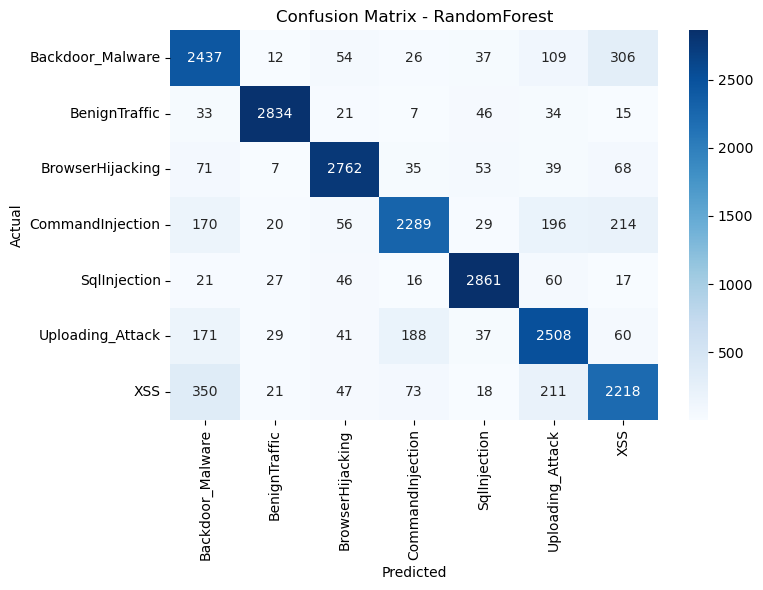

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25830
[LightGBM] [Info] Number of data points in the train set: 49000, number of used features: 128
[LightGBM] [Info] Start training from score -1.943200
[LightGBM] [Info] Start training from score -1.944483
[LightGBM] [Info] Start training from score -1.950923
[LightGBM] [Info] Start training from score -1.942203
[LightGBM] [Info] Start training from score -1.952791
[LightGBM] [Info] Start training from score -1.950779
[LightGBM] [Info] Start training from score -1.937092
accurcy :   0.8859523809523809        LightGBM
training_time : 31.103979349136353   inference_time_total: 0.46944093704223633   inference_time_per_sample: 2.2354330335344588e-05


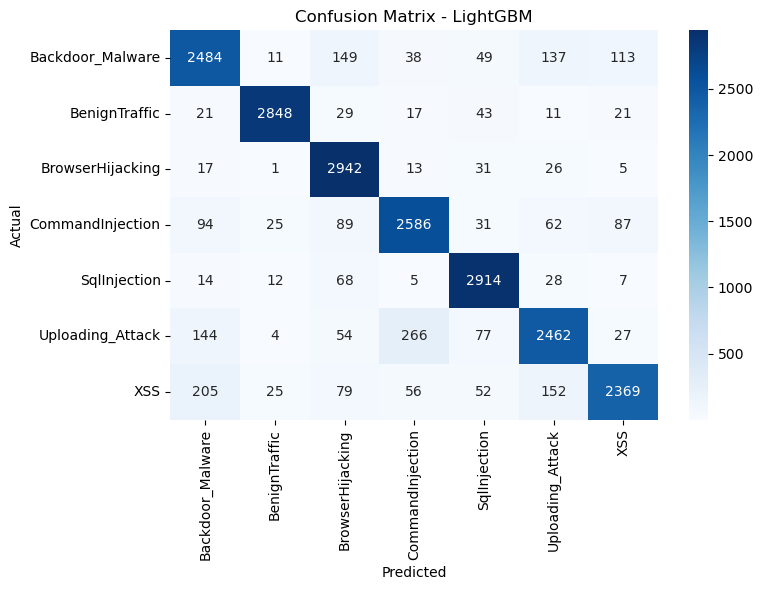

accurcy :   0.783047619047619        MLP
training_time : 297.20672249794006   inference_time_total: 0.024784088134765625   inference_time_per_sample: 1.1801946730840773e-06


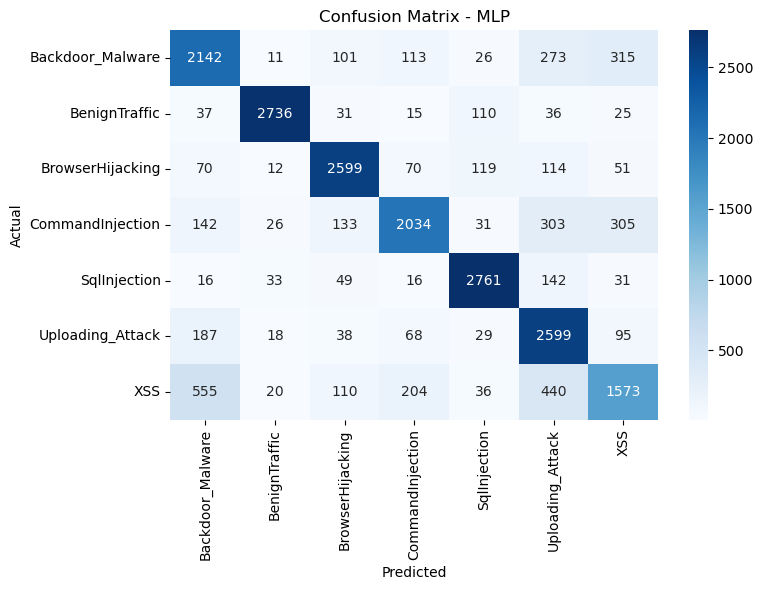

In [51]:
train_and_collect(RandomForestClassifier(random_state=42), 'RandomForest')
train_and_collect(LGBMClassifier(random_state=42), 'LightGBM')
train_and_collect(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42), 'MLP')



In [81]:
y_categorical = to_categorical(train_filter['label'])
X_train, X_test, y_train, y_test = train_test_split(train_filter.drop('label',axis=1), 
                                                    y_categorical, test_size=0.30, 
                                                    random_state=101)

x_train  = preprocessing.StandardScaler().fit_transform(X_train.values)
x_test  = preprocessing.StandardScaler().fit_transform(X_test.values)
y_categorical

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

accurcy :   0.721        DNN
training_time : 118.36898016929626   inference_time_total: 2.4557459354400635  inference_time_per_sample: 0.00011694028264000302


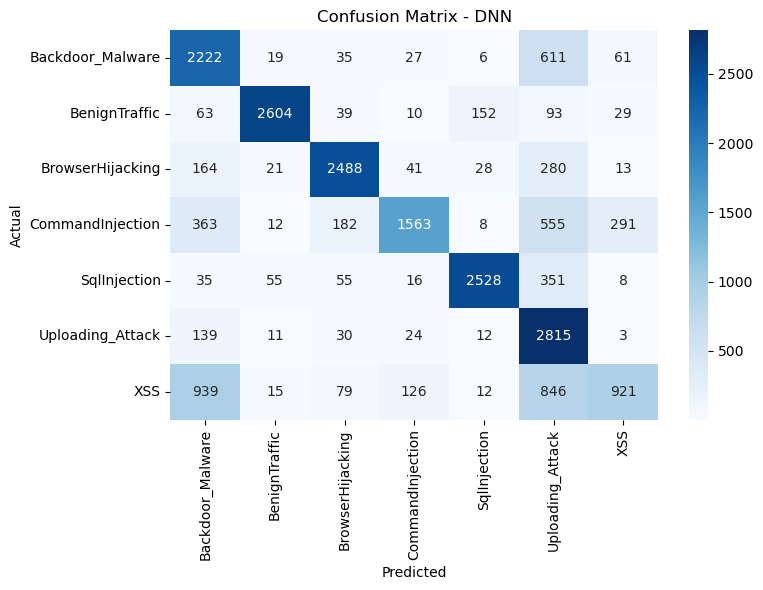

In [109]:
y_categorical = to_categorical(train_filter['label'])
model = Sequential([
    Dense(128, input_dim=x_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(y_categorical.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start_train = time.time()
history = model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=0)
end_train = time.time()
training_time = end_train - start_train

start_inference = time.time()
y_pred = model.predict(x_test, verbose=0)
end_inference = time.time()
inference_time_total = end_inference - start_inference
inference_time_per_sample = inference_time_total / x_test.shape[0]



y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
report = classification_report(y_test_labels, y_pred_labels, target_names=label_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report['model'] = 'DNN'
df_report['label'] = df_report.index
df_report['type'] = 'classification_report'
all_reports.append(df_report)
print('accurcy :  ', accuracy_score(y_pred_labels , y_test_labels) , '      ' , 'DNN') 
print('training_time :' , training_time , '  inference_time_total:', inference_time_total , ' inference_time_per_sample:' ,inference_time_per_sample)
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
plt.title('Confusion Matrix - DNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [111]:
final_report = pd.concat(all_reports, ignore_index=True)
final_report.to_csv('all_models_results.csv', encoding='utf-8-sig', index=False)

print(" Stored in all_models_results.csv.")

Stored in all_models_results.csv


In [113]:
all_result = pd.read_csv('all_models_results.csv')
all_result

,precision,recall,f1-score,support,model,label,type
0,0.749155,0.817511,0.781842,2981.000000,RandomForest,Backdoor_Malware,classification_report
1,0.960678,0.947826,0.954209,2990.000000,RandomForest,BenignTraffic,classification_report
2,0.912455,0.910049,0.911250,3035.000000,RandomForest,BrowserHijacking,classification_report
3,0.869021,0.769670,0.816334,2974.000000,RandomForest,CommandInjection,classification_report
4,0.928595,0.938648,0.933594,3048.000000,RandomForest,SqlInjection,classification_report
5,0.794425,0.826632,0.810208,3034.000000,RandomForest,Uploading_Attack,classification_report
6,0.765355,0.754935,0.760110,2938.000000,RandomForest,XSS,classification_report
7,0.852810,0.852810,0.852810,0.852810,RandomForest,accuracy,classification_report
8,0.854240,0.852182,0.852507,21000.000000,RandomForest,macro avg,classification_report
9,0.854699,0.852810,0.853055,21000.000000,RandomForest,weighted avg,classification_report
